# Solution 3

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (C): Spread and Swap Spread in November 2008

## Simplification of the setup

The date is Nov 4, 2008.

**Treasury bond**
* Suppose the Treasury bond matures exactly 30 years later, on Nov 4, 2038 rather than May 15, 2008. 
* The YTM of this freshly issued treasury is 4.193\% with a semiannual coupon of 4.50\%, same as is given in the case. (So we're just changing the maturity date to simplify things, but keeping the market data.)

**Swap**
* The fixed leg of the swap pays semiannually, with swap rate of 4.2560\%, as given in the case.
* The floating leg of the swap also pays semiannually--not quarterly--such that the payment dates are identical on both legs. Thus, it also resets the floating rate semiannually, not quarterly.
* The floating rate of the swap equals the repo rate used in the trade. Thus, these two rates cancel in the financing of the trade. (No need to consider the TED spread.) 

## Case Clarifications


### Duration Quotes
Bond
* Quote: Val01 of bond is .1746 per bp per \\$1 face value
* Class terminology: Modified dollar duration is .1746 per \\$100 face value

Swap
* Quote: DV01 of swap is 1.7mm per 1 billion notional.
* Class terminology: Modified dollar duration is 100(1.7/1000) per \\$100 face value.

Thus, modified dollar duration for each per 100 face is
* Bond = .1746
* Swap = .1700

### Hedge Ratio

In figuring out the hedge ratio, they set up the hedge per dollar of face value. 

    *so Mills would need to buy face amount \\$0.97 billion**
    
    No, this hedge should be for market value, not face amount given that the case is already using **modified** duration which includes the dirty price.

### Maturity Mismatch

The maturity of the bond is August 2038, whereas the date is Nov 2008. Thus, the bond has less than 30 years to maturity, yet he is entering a 30-year swap. 

For simplicity, we imagine the bond is issued in Nov 2008 and thus has maturity of 30 years at the time of the case.

However, then the case quotes for the Nov price and YTM of the bond no longer are accurate. Use one and adjust the other. Namely, we could...
    * use the Nov 4 **YTM** quoted in the case, and re-adjust the the bond.
    * use the Nov 4 **price** quoted in the case, and re-adjust the YTM.
    
We do the former, keep the quoted YTM, assume time-to-maturity of `30`, and recalculate the Nov 2008 price. (It is close to the quoted price in the case.)

***

## 1.0.

Report the price of the 30-year T-bond in Nov 2008. Given the discussion about `Maturity Mismatch`, we are repricing the bond, so it will not exactly equal `105` as reported in the case.

## 1.1

List the projected cashflows on May 4, 2009, exactly six months into the trade, on the first coupon and swap date.

## 1.2

What is the duration of...
* the T-bond
* the swap

Remember that...
* the swap can be decomposed into a fixed-rate bond and a floating-rate note
* a floating-rate note has duration equal to the time until the next reset. Thus, at initialization, it has duration equal to 0.5 years.

Is the duration for the "paying-fixed" swap positive or negative? Is it bigger or smaller in magnitude than the T-bond?

For this problem, calculate the Macauley duration and the dollar (Macauley) duration.

## 1.3

What hedge ratio should be used to balance the notional size of the Treasury bond with the notional size of the swap, such that it is a duration-neutral position?

Specifically, if the trader enters the swap paying fixed on \$500 million notional, how large of a position should they take in the Treasury bond?

## 1.4

Suppose it is May 4, 2009, exactly six months after putting the trade on.

The spread is at -28 bps due to...
* The YTM on a new 30-year bond has risen to 4.36\%
* The swap rate on a new 30-year swap has dropped to 4.08\%

Explain conceptually how this movement impacts the components of the trade.

## 1.5

Calculate the value of the position on May 4, 2009, immediately after the first coupon and swap payments and swap reset. 

* Calculate the revised price of the Treasury bond by assuming you can apply the (May 4) 30-year YTM as a discount rate to the 29.5 year bond. (We are just using this for a rough approximation. You know that good pricing would require a discount curve, but let's not get bogged down with that here.)


* Calculate the value of the swap by decomposing it into a fixed-rate bond and a floating-rate bond.
    * The 29.5 year fixed-rate leg is priced using the (May 4) 30-year swap rate as a discount rate.
    * The floating-rate leg is priced at par given that floating-rate notes are par immediately after resets.
    
**Note**

You are being asked to calculate these valuations using the exact formula between price, cashflows, and YTM discount rate. We are not simply approximating with duration, as we already know the position was set up with zero dollar duration.

From the Discussion 1 notebook, we have this formula expressing a bond's price as a function of the coupon, $c$, and the YTM, $y_j$.

$\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align*}
$

## 1.6

Accounting for the change in value of the positions, as well as the 6-month cashflows paid on May 4, 
* what is the net profit and loss (pnl) of the position?
* what is the return on the equity capital, considering that there was a 2\% haircut (equity contribution) on the size of the initial treasury bond position.

***

# <span style="color:red">Solution</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
def price_treasury_ytm(time_to_maturity, ytm, cpn_rate,freq=2,face=100):
    c = cpn_rate/freq
    y = ytm/freq
    
    rem = freq * (time_to_maturity % (1/freq))
    tau = freq * time_to_maturity - rem
    
    if round(tau)!=tau:
        print('warning')
    else:
        tau = round(tau)    
    
    pv = 0
    for i in range(1,tau):
        pv += 1 / (1+y)**i
    
    pv = c*pv + (1+c)/(1+y)**tau
    pv *= face
    
    if rem>0:
        pv += c*face
        pv /= (1+y)**rem
        
    return pv

In [3]:
def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

### Case Parameters

In [4]:
YTM = [0.04193, .0436]
CPNRATE = [0.0450, .0436]    
SWAPRATE = [.042560, .0408]

TPRICE = 105
PAR = 100

NOTIONAL = 500e6
HAIRCUT = .02

DELTATIME = .5
tau0 = 30
tau1 = tau0-DELTATIME

### Adjustments

In [5]:
USE_PAR_TBOND = False
# Set coupon on 30-year T bond to equal Nov 4 YTM
# Or stick with the coupon rate in the case, for the Aug 2008 T bond

if USE_PAR_TBOND:
    CPNRATE = [YTM[0], .0436]

    
    
DO_YTM = False

if DO_YTM:    
    pv_wrapper = lambda y: TPRICE - price_treasury_ytm(tau0,y,CPNRATE[0])    
    YTM = [fsolve(pv_wrapper,.04)[0], .0436]
else:
    TPRICE = price_treasury_ytm(tau0,YTM[0],CPNRATE[0])

### Market environment

In [6]:
summary = pd.DataFrame(index=['coupon rate','YTM','swap rate'],columns = ['Nov 2008','May 2009'],dtype=float)
summary.loc['coupon rate'] = CPNRATE
summary.loc['YTM'] = YTM
summary.loc['swap rate'] = SWAPRATE
summary.loc['YTM spread'] = summary.loc['swap rate'] - summary.loc['YTM']
summary.loc['coupon spread'] = summary.loc['swap rate'] - summary.loc['coupon rate']
summary.style.format('{:.2%}')

,Nov 2008,May 2009
coupon rate,4.50%,4.36%
YTM,4.19%,4.36%
swap rate,4.26%,4.08%
YTM spread,0.06%,-0.28%
coupon spread,-0.24%,-0.28%


# <span style="color:red">1.1</span>

#### SOFR rate cancels

No need to account for the repo rate or the swap's floating payment, as they both are modeled in this problem with SOFR, and thus net to zero.

In [7]:
SOFR = np.nan

### Cashflows

In [8]:
CF = pd.DataFrame(index=['T bond','Repo','Swap (floating leg)','Swap (fixed leg)'],columns=['May 2009'],dtype=float)
CF.loc['Repo'] -SOFR
CF.loc['Swap (floating leg)'] = SOFR
CF.loc[['T bond']] = PAR * CPNRATE[0] /2
CF.loc[['Swap (fixed leg)']] = -PAR * SWAPRATE[0]/2
CF.loc['Net Payment'] = CF.sum(axis=0)
CF.style.format('${:,.2f}')

,May 2009
T bond,$2.25
Repo,$nan
Swap (floating leg),$nan
Swap (fixed leg),$-2.13
Net Payment,$0.12


# <span style="color:red">1.2</span>

In [9]:
tab_duration = pd.DataFrame(dtype=float, index=['T bond','fixed leg', 'floating leg'], columns=['duration'])
tab_duration.loc['T bond'] = duration_closed_formula(tau0, summary.loc['YTM','Nov 2008'], summary.loc['coupon rate','Nov 2008'])
tab_duration.loc['fixed leg'] = duration_closed_formula(tau0, summary.loc['swap rate','Nov 2008'])
tab_duration.loc['floating leg'] = .5

tab_duration['dollar duration'] = tab_duration['duration'] * np.array([TPRICE, PAR, PAR])

tab_duration.loc['swap'] = tab_duration.loc['fixed leg'] - tab_duration.loc['floating leg']

tab_duration.loc['net'] = tab_duration.loc['T bond'] - tab_duration.loc['swap']

tab_duration

,duration,dollar duration
T bond,17.083633,1797.425100
fixed leg,17.212744,1721.274445
floating leg,0.500000,50.000000
swap,16.712744,1671.274445
net,0.370889,126.150654


# <span style="color:red">1.3</span>

Match dollar duration by ensuring that the ratio of contracts equals the ratio of dollar duration:

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

In [10]:
hedge_ratio = tab_duration.loc['swap','dollar duration'] / tab_duration.loc['T bond','dollar duration']
contracts = pd.DataFrame(NOTIONAL * np.array([hedge_ratio /TPRICE, -1/PAR]), index=['T bond','swap'], columns=['positions'])
contracts

,positions
T bond,4.418719e+06
swap,-5.000000e+06


# <span style="color:red">1.4</span>

The rising YTM on the T bond suggests...
* lower (adjusted) price for the T-bond.
* we are long the T-bond, so this would be a loss.

The lower swap rate suggests...
* higher value on the fixed leg of a swap.
* we are paying fixed, (ie short the fixed leg), so this would again be a loss.

The floating leg of the swap and repo rate cance.

# <span style="color:red">1.5</span>

In [11]:
prices = pd.DataFrame(index=['T bond', 'swap'],dtype=float,columns=['Nov 2008'])

if USE_PAR_TBOND:
    prices.loc['T bond','Nov 2008'] = price_treasury_ytm(tau0, summary.loc['YTM','Nov 2008'], summary.loc['coupon rate','Nov 2008'])
else:
    prices.loc['T bond','Nov 2008'] = TPRICE

prices.loc['swap','Nov 2008'] = PAR - PAR

prices.loc['T bond','May 2009'] = price_treasury_ytm(tau1, summary.loc['YTM','May 2009'], summary.loc['coupon rate','Nov 2008'])
prices.loc['swap','May 2009'] = price_treasury_ytm(tau1, summary.loc['swap rate','May 2009'], summary.loc['swap rate','Nov 2008']) - PAR

prices.style.format('${:,.2f}')

,Nov 2008,May 2009
T bond,$105.21,$102.31
swap,$0.00,$3.00


# <span style="color:red">1.6</span>

In [12]:
pnl=pd.DataFrame(dtype=float,index=['T bond','swap'],columns=['cashflow'])

pnl['cashflow'] = CF.loc[['T bond','Swap (fixed leg)']].values * contracts.abs().values
pnl['capital gains'] = prices.diff(axis=1)['May 2009'].values * contracts.values[:,0]

pnl.loc['net'] = pnl.sum()

pnl['total'] = pnl.sum(axis=1)

pnl.style.format('${:,.2f}',na_rep='')

,cashflow,capital gains,total
T bond,"$9,942,118.29","$-12,822,597.70","$-2,880,479.41"
swap,"$-10,640,000.00","$-15,016,747.03","$-25,656,747.03"
net,"$-697,881.71","$-27,839,344.73","$-28,537,226.43"


In [13]:
capital = pd.DataFrame(prices.iloc[:,0].values * contracts.values[:,0], index=['T bond','swap'],columns=['assets'])
capital['equity'] = capital['assets'] * HAIRCUT
capital.loc['net'] = capital.sum()

capital['pnl'] = pnl['total']
capital['return'] = capital['pnl']/capital['equity']
capital.loc[['T bond','swap'],'return'] = np.nan

capital.style.format({'assets':'${:,.2f}','equity':'${:,.2f}','pnl':'${:,.2f}','return':'{:.2%}'},na_rep='')

,assets,equity,pnl,return
T bond,"$464,907,952.46","$9,298,159.05","$-2,880,479.41",
swap,$-0.00,$-0.00,"$-25,656,747.03",
net,"$464,907,952.46","$9,298,159.05","$-28,537,226.43",-306.91%


***

# Extra: Swap Spread Since The Case

In [14]:
filepath = '../data/sofr_swaps.xlsx'
swaps_raw = pd.read_excel(filepath,sheet_name='data').set_index('Unnamed: 0')
swaps_raw.columns = swaps_raw.columns.astype(float)
swaps_raw.index.name = 'date'

swaps_sofr = swaps_raw.copy()

In [15]:
filepath = '../data/libor_swaps.xlsx'
swaps_raw = pd.read_excel(filepath,sheet_name='data').set_index('Unnamed: 0')
swaps_raw.columns = swaps_raw.columns.astype(float)
swaps_raw.index.name = 'date'

swaps_libor = swaps_raw.copy()

In [16]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

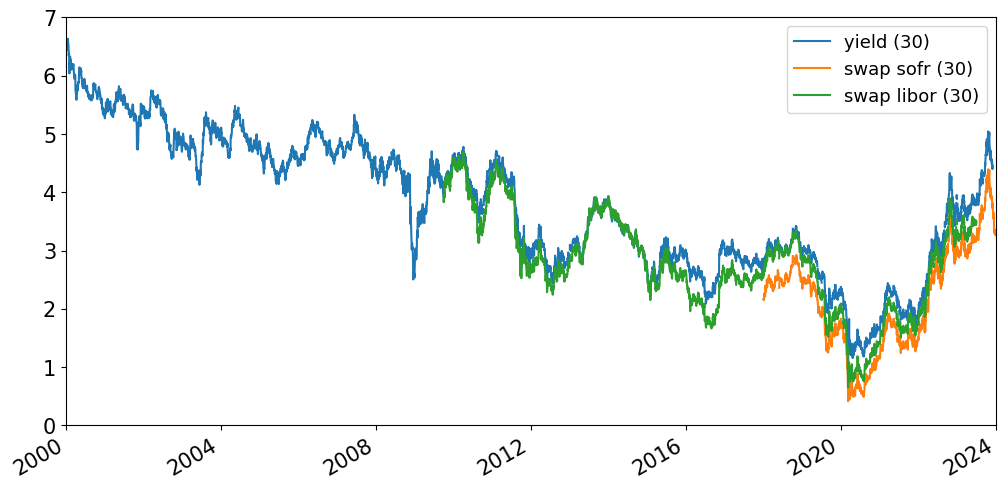

In [17]:
tab = pd.concat([yields[30],swaps_sofr[30],swaps_libor[30]],axis=1)
tab.columns = ['yield (30)','swap sofr (30)','swap libor (30)']
tab.plot(xlim=('2000','2024'),ylim=(0,7));

Take the mean of the libor and sofr swaps for dates where both exist.

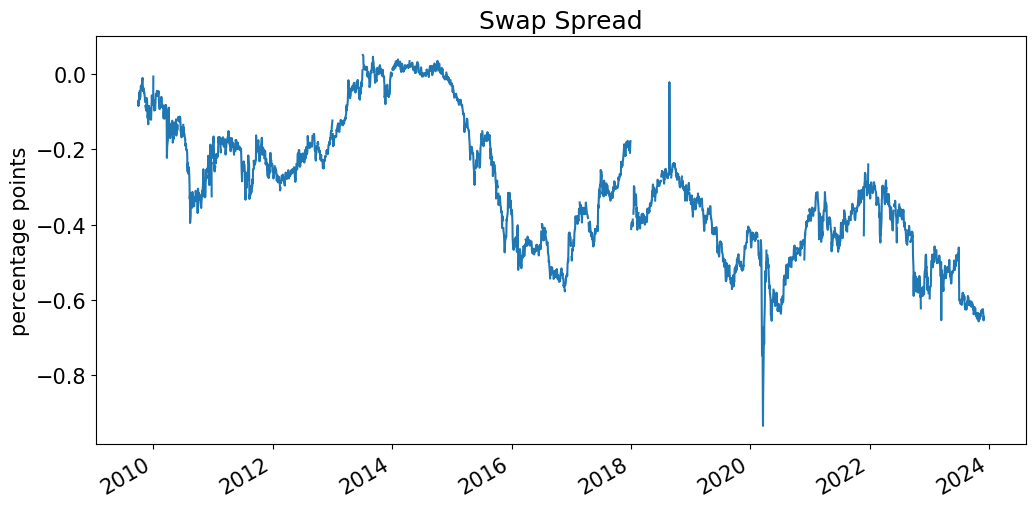

In [18]:
tab['swap spread'] = tab.iloc[:,[1,2]].mean(axis=1)-tab.iloc[:,0]
tab['swap spread'].plot(title='Swap Spread',ylabel='percentage points');